# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import json
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

from preprocessing.datasets import YagoECQ
from preprocessing.utils import extract_name_from_yago_uri
from susceptibility_scores import construct_paths_and_dataset_kwargs

### Preamble

In [3]:
##################
### Parameters ###
##################

# Data parameters
DATASET_NAME = "YagoECQ"
RAW_DATA_PATH = "data/YagoECQ/yago_qec.json"
SEED = 0
MODEL_ID = "EleutherAI/pythia-6.9b-deduped"
LOAD_IN_8BIT = True
MAX_CONTEXTS = 500
MAX_ENTITIES = 100
CAP_PER_TYPE = False
ABLATE_OUT_RELEVANT_CONTEXTS = False
UNIFORM_CONTEXTS = True
DEDUPLICATE_ENTITIES = True

OVERWRITE = True
ENTITY_TYPES = ["entities", "gpt_fake_entities"]
# ENTITY_TYPES = ["entities", "fake_entities"]
QUERY_TYPES = ["closed", "open"]
# QUERY_TYPES = ["closed"]
# ANSWER_MAP = {
#     0: [1621, 642, 7651, 2302, 2369, 7716],
#     1: [6279, 4754, 22487, 4374, 9820, 24239],
# }
ANSWER_MAP = None

# Model parameters
BATCH_SZ = 16

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

In [4]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)
QUERY_IDS = list(yago_qec.keys())
QUERY_ID = QUERY_IDS[0]
QUERY_ID = "http://schema.org/alumniOf"
# QUERY_ID = "reverse-http://schema.org/manufacturer"
SUBNAME = f"{extract_name_from_yago_uri(QUERY_ID)[0]}_{extract_name_from_yago_uri(QUERY_ID)[1]}"
QUERY_IDS[:5], len(QUERY_IDS)

(['http://schema.org/alumniOf',
  'http://schema.org/duration',
  'reverse-http://schema.org/director',
  'http://schema.org/address',
  'http://schema.org/duns'],
 56)

In [5]:
for qid, v in yago_qec.items():
    print(qid, len(v["entities"]), len(set(v["entities"])))

http://schema.org/alumniOf 1000 999
http://schema.org/duration 1000 999
reverse-http://schema.org/director 1000 936
http://schema.org/address 1000 997
http://schema.org/duns 119 119
http://schema.org/founder 1000 987
http://schema.org/elevation 1000 998
reverse-http://schema.org/editor 378 314
http://schema.org/lyricist 1000 960
http://schema.org/memberOf 1000 999
http://schema.org/about 1000 991
http://schema.org/gtin 21 18
http://schema.org/administrates 1000 800
http://schema.org/leader 1000 943
http://schema.org/illustrator 226 216
http://schema.org/material 1000 962
http://schema.org/children 1000 994
http://schema.org/dateCreated 1000 999
http://schema.org/editor 378 263
reverse-http://schema.org/lyricist 1000 746
http://schema.org/actor 1000 991
reverse-http://schema.org/memberOf 1000 841
http://schema.org/director 1000 998
http://schema.org/contentLocation 1000 992
http://schema.org/homeLocation 1000 995
http://schema.org/knowsLanguage 1000 1000
http://schema.org/dissolutionDat

In [6]:
# Construct paths from run parameters and construct DATASET_KWARGS_IDENTIFIABLE
(
    data_dir,
    input_dir,
    entities_path,
    contexts_path,
    queries_path,
    answers_path,
    val_data_path,
    model_dir,
    results_dir,
    val_results_path,
    data_id,
    model_id,
    DATASET_KWARGS_IDENTIFIABLE,
) = construct_paths_and_dataset_kwargs(
    DATASET_NAME=DATASET_NAME,
    RAW_DATA_PATH=RAW_DATA_PATH,
    SEED=SEED,
    MODEL_ID=MODEL_ID,
    LOAD_IN_8BIT=LOAD_IN_8BIT,
    QUERY_ID=QUERY_ID,
    MAX_CONTEXTS=MAX_CONTEXTS,
    MAX_ENTITIES=MAX_ENTITIES,
    CAP_PER_TYPE=CAP_PER_TYPE,
    ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
    UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
    DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
    OVERWRITE=OVERWRITE,
    ENTITY_TYPES=ENTITY_TYPES,
    QUERY_TYPES=QUERY_TYPES,
    ANSWER_MAP=ANSWER_MAP,
)

Data dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0
Model dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/models/EleutherAI/pythia-6.9b-deduped-8bit


In [7]:
# Analysis dir
analysis_dir = os.path.join("analysis", DATASET_NAME)
print(f"Analysis dir: {analysis_dir}")

Analysis dir: analysis/YagoECQ


In [8]:
os.makedirs(input_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(analysis_dir, exist_ok=True)
dataset = getattr(sys.modules[__name__], DATASET_NAME)(**DATASET_KWARGS_IDENTIFIABLE)

Overwriting datasets (if they already exist) at data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/inputs/entities.json, data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/inputs/answers.json, data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/inputs/contexts.json, and data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/inputs/queries.json.
Number of entities in each entity type must be the same, instead received lengths [1000, 386] ['entities', 'gpt_fake_entities']. Truncating entity size per type to be 386


In [9]:
# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [10]:
# GPU stuff
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# wandb stuff
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), "analysis.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    mode="online",
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smalle

{'DATASET_NAME': 'YagoECQ', 'RAW_DATA_PATH': 'data/YagoECQ/yago_qec.json', 'SEED': 0, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'MAX_CONTEXTS': 500, 'MAX_ENTITIES': 100, 'CAP_PER_TYPE': False, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, 'UNIFORM_CONTEXTS': True, 'DEDUPLICATE_ENTITIES': True, 'OVERWRITE': True, 'ENTITY_TYPES': ['entities', 'gpt_fake_entities'], 'QUERY_TYPES': ['closed', 'open'], 'ANSWER_MAP': None, 'BATCH_SZ': 16, 'PROJECT_NAME': 'context-vs-bias', 'GROUP_NAME': None, 'TAGS': ['yago', 'analysis'], 'LOG_DATASETS': True, 'QUERY_IDS': ['http://schema.org/alumniOf', 'http://schema.org/duration', 'reverse-http://schema.org/director', 'http://schema.org/address', 'http://schema.org/duns', 'http://schema.org/founder', 'http://schema.org/elevation', 'reverse-http://schema.org/editor', 'http://schema.org/lyricist', 'http://schema.org/memberOf', 'http://schema.org/about', 'http://schema.org/gtin', 'http://schema.org/administrates', 'http://schema.org/leader',

### Load Data

In [12]:
from ast import literal_eval

val_df_contexts_per_qe = pd.read_csv(
    val_results_path,
    index_col=0,
    converters={"contexts": literal_eval, "entity": literal_eval},
)

In [13]:
# After loading/preprocessing your dataset, log it as an artifact to W&B
if LOG_DATASETS:
    print(f"Logging datasets to w&b run {wandb.run}.")
    artifact = wandb.Artifact(name=data_id, type="dataset")
    artifact.add_dir(local_path=input_dir)
    run.log_artifact(artifact)

wandb: Adding directory to artifact (./data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/inputs)... Done. 0.2s


Logging datasets to w&b run <wandb.sdk.wandb_run.Run object at 0x2ae0a658be50>.


### Analyze Data

In [14]:
val_df_contexts_per_qe.head()

q_id                               query_form  \
0  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
1  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
2  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
3  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
4  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   

                  entity                                          answer  \
0      (Karl Uchermann,)                    Academy of Fine Arts, Munich   
1         (Lena Moreno,)  University of Music and Performing Arts Vienna   
2  (Alexander Z. Kruse,)                 Art Students League of New York   
3   (Geoffrey Fletcher,)                                     New College   
4      (Mikael Abramov,)                         University of Rochester   

                                            contexts  susceptibility_score  \
0  [Aaliyah Johnson is an alum of Katedralskolan....              0.013037   
1  [Aaliyah Johnson is an alum of Katedralskolan....              0.018757   
2  [Aaliyah Johnson is an alum of Katedralskolan....              0.016097   
3  [Aaliyah Johnson is an alum of Katedralskolan....              0.017654   
4  [Aaliyah Johnson is an alum of Katedralskolan....              0.022003   

                                  full_query_example  
0  Aaliyah Johnson is an alum of Katedralskolan.\...  
1  Aaliyah Johnson is an alum of Katedralskolan.\...  
2  Aaliyah Johnson is an alum of Katedralskolan.\...  
3  Aaliyah Johnson is an alum of Katedralskolan.\...  
4  Aaliyah Johnson is an alum of Katedralskolan.\...

In [15]:
val_df_contexts_per_qe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   q_id                  400 non-null    object 
 1   query_form            400 non-null    object 
 2   entity                400 non-null    object 
 3   answer                400 non-null    object 
 4   contexts              400 non-null    object 
 5   susceptibility_score  400 non-null    float64
 6   full_query_example    400 non-null    object 
dtypes: float64(1), object(6)
memory usage: 25.0+ KB


In [16]:
val_df_contexts_per_qe["entity"].value_counts()

(Karl Uchermann,)       4
(Aya Hashem,)           4
(Nia Robinson,)         4
(Camila Santos,)        4
(Harvey Dow Gibson,)    4
                       ..
(Bibi Bakare-Yusuf,)    4
(Oleh Liashko,)         4
(Mark Ehrenfried,)      4
(Isabella Lam,)         4
(Carmen Fuentes,)       4
Name: entity, Length: 100, dtype: int64

In [17]:
val_df_contexts_per_qe.iloc[0]["contexts"][:10]

['Aaliyah Johnson is an alum of Katedralskolan.\n',
 'Aaliyah Johnson is an alum of Stonyhurst College.\n',
 "Aaliyah Johnson is an alum of St Benet's Hall.\n",
 'Aaliyah Johnson is an alum of Technion – Israel Institute of Technology.\n',
 "Aaliyah Johnson is an alum of People's Public Security University of China.\n",
 'Adam Makowicz is an alum of University of Colorado Boulder.\n',
 'Adam Makowicz is an alum of Music conservatory of Naples.\n',
 'Adam Makowicz is an alum of Benton Academy.\n',
 'Adam Makowicz is an alum of Damascus University.\n',
 'Adam Makowicz is an alum of St. Cloud State University.\n']

In [18]:
# import re

# p = r"of\s(.*?)(?=\sis\b)"
# c_ents = [
#     re.search(p, text).group(1) for text in val_df_contexts_per_qe.iloc[0]["contexts"]
# ]
# ents = val_df_contexts_per_qe["entity"].tolist()
# if (
#     DATASET_KWARGS_IDENTIFIABLE["ablate_out_relevant_contexts"]
#     and len(set(c_ents).intersection(set(ents))) != 0
# ):
#     raise ValueError(
#         "ablate_out_relevant_contexts is True, but the contexts contain entities in the entities list."
#     )

In [19]:
entities_df_tidy = pd.DataFrame(
    [
        (k, ent)
        for k, ents in yago_qec[QUERY_ID].items()
        for ent in ents
        if k in {"entities", "fake_entities", "gpt_fake_entities"}
    ],
    columns=["type", "entity"],
)
entities_df_tidy["entity"] = entities_df_tidy["entity"].apply(lambda x: (x,))

In [20]:
# entities_df = pd.DataFrame(
#     {k: v for k, v in yago_qec[QUERY_ID].items() if k in {"entities", "fake_entities", "gpt_fake_entities"}}
# )
# real_ents = set(entities_df["entities"])
# fake_ents = set(entities_df["fake_entities"])
# print("# unique real ents:", len(real_ents))
# print("# unique fake ents:", len(fake_ents))
# print("# overlapping ents:", len(real_ents.intersection(fake_ents)))
# print("Overlapping ents:", real_ents.intersection(fake_ents))
# print(entities_df["entities"].value_counts(), entities_df["fake_entities"].value_counts())

# entities_df_tidy = entities_df.melt(var_name="type", value_name="entity")
# print(entities_df_tidy.head())
# entities_df_tidy["entity"] = entities_df_tidy["entity"].apply(lambda x: (x,))
# entities_df_tidy.head()
# entities_df_tidy.info()

In [21]:
entities_df_tidy = entities_df_tidy.drop_duplicates()

In [22]:
entities_df_tidy["entity"].value_counts()

(Phil Fortunato,)           1
(Isis,)                     1
(Gishar Costronovan,)       1
(Bruce Multy Carey,)        1
(Farmin Farmin,)            1
                           ..
(William C. Hayes,)         1
(Hiroyuki Yoshida,)         1
(Lionel Herbert Clarke,)    1
(Marlon Daniel,)            1
(Hugo Andersson,)           1
Name: entity, Length: 2385, dtype: int64

In [23]:
entities_df_tidy[entities_df_tidy["type"] == "entities"][
    "entity"
].value_counts(), entities_df_tidy[entities_df_tidy["type"] == "fake_entities"][
    "entity"
].value_counts()

((Phil Fortunato,)        1
 (Talal Al-Barazi,)       1
 (Zeno Payne Metcalf,)    1
 (Chris Heaphy,)          1
 (Carly Mark,)            1
                         ..
 (Barton Lynch,)          1
 (Lee Young-jin,)         1
 (Paul Girolami,)         1
 (Charles Oxenden,)       1
 (Charles Moseley,)       1
 Name: entity, Length: 999, dtype: int64,
 (Mark Sainin,)        1
 (Tamias,)             1
 (Ormessis,)           1
 (Murray Morrison,)    1
 (Audibis,)            1
                      ..
 (Adam Tedrell,)       1
 (Albert Much,)        1
 (Ronald Attack,)      1
 (Mary Todd,)          1
 (Mark Halter,)        1
 Name: entity, Length: 1000, dtype: int64)

In [24]:
s_multiple_entities = entities_df_tidy["entity"].value_counts() > 1
# set(s_multiple_entities[s_multiple_entities].index)
# val_df_contexts_per_qe["entity"].isin(
#     set(s_multiple_entities[s_multiple_entities].index)
# )

In [25]:
val_df_contexts_per_qe["entity"].value_counts()

(Karl Uchermann,)       4
(Aya Hashem,)           4
(Nia Robinson,)         4
(Camila Santos,)        4
(Harvey Dow Gibson,)    4
                       ..
(Bibi Bakare-Yusuf,)    4
(Oleh Liashko,)         4
(Mark Ehrenfried,)      4
(Isabella Lam,)         4
(Carmen Fuentes,)       4
Name: entity, Length: 100, dtype: int64

In [26]:
# val_df_contexts_per_qe["entity"]
entities_df_tidy["entity"].isin(
    set(val_df_contexts_per_qe["entity"]).intersection(set(entities_df_tidy["entity"]))
).value_counts()

False    2285
True      100
Name: entity, dtype: int64

In [27]:
qids_to_ec = pd.DataFrame(
    [(k, v["entity_types"]) for k, v in yago_qec.items()],
    columns=["q_id", "entity_classes"],
)

In [28]:
val_df_per_qe = val_df_contexts_per_qe.merge(
    entities_df_tidy,
    left_on="entity",
    right_on="entity",
    how="left",
)[
    [
        "q_id",
        "query_form",
        "entity",
        "answer",
        "contexts",
        "type",
        "susceptibility_score",
    ]
]
val_df_per_qe = val_df_per_qe.merge(qids_to_ec)
val_df_per_qe

q_id                               query_form  \
0    http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
1    http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
2    http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
3    http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
4    http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
..                          ...                                      ...   
395  http://schema.org/alumniOf                   {entity} is an alum of   
396  http://schema.org/alumniOf                   {entity} is an alum of   
397  http://schema.org/alumniOf                   {entity} is an alum of   
398  http://schema.org/alumniOf                   {entity} is an alum of   
399  http://schema.org/alumniOf                   {entity} is an alum of   

                       entity                                          answer  \
0           (Karl Uchermann,)                    Academy of Fine Arts, Munich   
1              (Lena Moreno,)  University of Music and Performing Arts Vienna   
2       (Alexander Z. Kruse,)                 Art Students League of New York   
3        (Geoffrey Fletcher,)                                     New College   
4           (Mikael Abramov,)                         University of Rochester   
..                        ...                                             ...   
395  (William G. Batchelder,)                              Medina High School   
396             (Mateo Cruz,)                    Samuel J. Tilden High School   
397         (Antonín Baudyš,)            Czech Technical University in Prague   
398       (Augustin Banyaga,)                            University of Geneva   
399         (Carmen Fuentes,)                                  Lycée Henri-IV   

                                              contexts               type  \
0    [Aaliyah Johnson is an alum of Katedralskolan....           entities   
1    [Aaliyah Johnson is an alum of Katedralskolan....  gpt_fake_entities   
2    [Aaliyah Johnson is an alum of Katedralskolan....           entities   
3    [Aaliyah Johnson is an alum of Katedralskolan....           entities   
4    [Aaliyah Johnson is an alum of Katedralskolan....  gpt_fake_entities   
..                                                 ...                ...   
395  [Aaliyah Johnson is an alum of Katedralskolan....           entities   
396  [Aaliyah Johnson is an alum of Katedralskolan....  gpt_fake_entities   
397  [Aaliyah Johnson is an alum of Katedralskolan....           entities   
398  [Aaliyah Johnson is an alum of Katedralskolan....           entities   
399  [Aaliyah Johnson is an alum of Katedralskolan....  gpt_fake_entities   

     susceptibility_score              entity_classes  
0                0.013037  [http://schema.org/Person]  
1                0.018757  [http://schema.org/Person]  
2                0.016097  [http://schema.org/Person]  
3                0.017654  [http://schema.org/Person]  
4                0.022003  [http://schema.org/Person]  
..                    ...                         ...  
395              0.704787  [http://schema.org/Person]  
396              0.666385  [http://schema.org/Person]  
397              0.455580  [http://schema.org/Person]  
398              0.794082  [http://schema.org/Person]  
399              0.794194  [http://schema.org/Person]  

[400 rows x 8 columns]

In [29]:
val_df_per_qe["entity"].value_counts()

(Karl Uchermann,)       4
(Aya Hashem,)           4
(Nia Robinson,)         4
(Camila Santos,)        4
(Harvey Dow Gibson,)    4
                       ..
(Bibi Bakare-Yusuf,)    4
(Oleh Liashko,)         4
(Mark Ehrenfried,)      4
(Isabella Lam,)         4
(Carmen Fuentes,)       4
Name: entity, Length: 100, dtype: int64

In [30]:
query_forms = val_df_per_qe["query_form"].unique()
query_forms

array(['Q: Is {entity} an alum of {answer}?\nA:',
       'Q: Does {answer} count {entity} as one of its alumni?\nA:',
       'Q: Which institution or organization is {entity} an alum of?\nA:',
       '{entity} is an alum of'], dtype=object)

In [31]:
closed_qfs = yago_qec[QUERY_ID]["query_forms"]["closed"]
open_qfs = yago_qec[QUERY_ID]["query_forms"]["open"]

val_df_per_qe.loc[val_df_per_qe["query_form"].isin(closed_qfs), "query_type"] = "closed"
val_df_per_qe.loc[val_df_per_qe["query_form"].isin(open_qfs), "query_type"] = "open"
val_df_per_qe

q_id                               query_form  \
0    http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
1    http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
2    http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
3    http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
4    http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
..                          ...                                      ...   
395  http://schema.org/alumniOf                   {entity} is an alum of   
396  http://schema.org/alumniOf                   {entity} is an alum of   
397  http://schema.org/alumniOf                   {entity} is an alum of   
398  http://schema.org/alumniOf                   {entity} is an alum of   
399  http://schema.org/alumniOf                   {entity} is an alum of   

                       entity                                          answer  \
0           (Karl Uchermann,)                    Academy of Fine Arts, Munich   
1              (Lena Moreno,)  University of Music and Performing Arts Vienna   
2       (Alexander Z. Kruse,)                 Art Students League of New York   
3        (Geoffrey Fletcher,)                                     New College   
4           (Mikael Abramov,)                         University of Rochester   
..                        ...                                             ...   
395  (William G. Batchelder,)                              Medina High School   
396             (Mateo Cruz,)                    Samuel J. Tilden High School   
397         (Antonín Baudyš,)            Czech Technical University in Prague   
398       (Augustin Banyaga,)                            University of Geneva   
399         (Carmen Fuentes,)                                  Lycée Henri-IV   

                                              contexts               type  \
0    [Aaliyah Johnson is an alum of Katedralskolan....           entities   
1    [Aaliyah Johnson is an alum of Katedralskolan....  gpt_fake_entities   
2    [Aaliyah Johnson is an alum of Katedralskolan....           entities   
3    [Aaliyah Johnson is an alum of Katedralskolan....           entities   
4    [Aaliyah Johnson is an alum of Katedralskolan....  gpt_fake_entities   
..                                                 ...                ...   
395  [Aaliyah Johnson is an alum of Katedralskolan....           entities   
396  [Aaliyah Johnson is an alum of Katedralskolan....  gpt_fake_entities   
397  [Aaliyah Johnson is an alum of Katedralskolan....           entities   
398  [Aaliyah Johnson is an alum of Katedralskolan....           entities   
399  [Aaliyah Johnson is an alum of Katedralskolan....  gpt_fake_entities   

     susceptibility_score              entity_classes query_type  
0                0.013037  [http://schema.org/Person]     closed  
1                0.018757  [http://schema.org/Person]     closed  
2                0.016097  [http://schema.org/Person]     closed  
3                0.017654  [http://schema.org/Person]     closed  
4                0.022003  [http://schema.org/Person]     closed  
..                    ...                         ...        ...  
395              0.704787  [http://schema.org/Person]       open  
396              0.666385  [http://schema.org/Person]       open  
397              0.455580  [http://schema.org/Person]       open  
398              0.794082  [http://schema.org/Person]       open  
399              0.794194  [http://schema.org/Person]       open  

[400 rows x 9 columns]

In [32]:
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]].sort_values(
    by="susceptibility_score"
)

q_id                               query_form  \
37  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
80  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
0   http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
89  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
24  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
..                         ...                                      ...   
63  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
52  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
19  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
25  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   
49  http://schema.org/alumniOf  Q: Is {entity} an alum of {answer}?\nA:   

                  entity                                             answer  \
37          (Nils Vogt,)              Norwegian National Academy of Theatre   
80     (Hans Heyerdahl,)  Norwegian National Academy of Craft and Art In...   
0      (Karl Uchermann,)                       Academy of Fine Arts, Munich   
89  (Dimitrios Soutsos,)     National and Kapodistrian University of Athens   
24   (Bernard Soustrot,)                             Conservatoire de Paris   
..                   ...                                                ...   
63         (Aya Hashem,)                                    Oberlin College   
52       (Israel Zolli,)                             University of Florence   
19        (Nana Gecaga,)               American InterContinental University   
25      (Aria Al-Farsi,)                              University of Münster   
49    (Aaliyah Johnson,)                             Morningside University   

                                             contexts               type  \
37  [Aaliyah Johnson is an alum of Katedralskolan....           entities   
80  [Aaliyah Johnson is an alum of Katedralskolan....           entities   
0   [Aaliyah Johnson is an alum of Katedralskolan....           entities   
89  [Aaliyah Johnson is an alum of Katedralskolan....           entities   
24  [Aaliyah Johnson is an alum of Katedralskolan....           entities   
..                                                ...                ...   
63  [Aaliyah Johnson is an alum of Katedralskolan....  gpt_fake_entities   
52  [Aaliyah Johnson is an alum of Katedralskolan....           entities   
19  [Aaliyah Johnson is an alum of Katedralskolan....           entities   
25  [Aaliyah Johnson is an alum of Katedralskolan....  gpt_fake_entities   
49  [Aaliyah Johnson is an alum of Katedralskolan....  gpt_fake_entities   

    susceptibility_score              entity_classes query_type  
37              0.012010  [http://schema.org/Person]     closed  
80              0.012698  [http://schema.org/Person]     closed  
0               0.013037  [http://schema.org/Person]     closed  
89              0.013639  [http://schema.org/Person]     closed  
24              0.013916  [http://schema.org/Person]     closed  
..                   ...                         ...        ...  
63              0.025428  [http://schema.org/Person]     closed  
52              0.026538  [http://schema.org/Person]     closed  
19              0.026853  [http://schema.org/Person]     closed  
25              0.028876  [http://schema.org/Person]     closed  
49              0.035847  [http://schema.org/Person]     closed  

[100 rows x 9 columns]

In [33]:
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]][
    ["entity", "type", "susceptibility_score"]
].sort_values(by="susceptibility_score")

entity               type  susceptibility_score
37          (Nils Vogt,)           entities              0.012010
80     (Hans Heyerdahl,)           entities              0.012698
0      (Karl Uchermann,)           entities              0.013037
89  (Dimitrios Soutsos,)           entities              0.013639
24   (Bernard Soustrot,)           entities              0.013916
..                   ...                ...                   ...
63         (Aya Hashem,)  gpt_fake_entities              0.025428
52       (Israel Zolli,)           entities              0.026538
19        (Nana Gecaga,)           entities              0.026853
25      (Aria Al-Farsi,)  gpt_fake_entities              0.028876
49    (Aaliyah Johnson,)  gpt_fake_entities              0.035847

[100 rows x 3 columns]

In [34]:
val_df_per_qe["type"].unique()

array(['entities', 'gpt_fake_entities'], dtype=object)

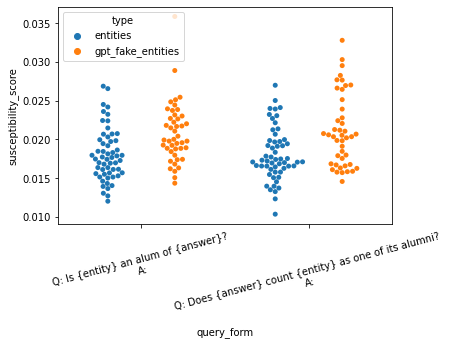

In [35]:
fig, ax = plt.subplots()
plot = sns.swarmplot(
    data=val_df_per_qe[val_df_per_qe["query_type"] == "closed"],
    x="query_form",
    y="susceptibility_score",
    hue="type",
    ax=ax,
    # size=5,
    # hue="is_real",
    dodge=True,
    hue_order=ENTITY_TYPES,
    # jitter=0.1,
    # legend="full",
)
for tick in ax.get_xticklabels():
    tick.set_rotation(15)
plot_name = f"plot_susscore_vs_queryform_real_fake_{SUBNAME}"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path)
wandb.log({plot_name: wandb.Image(fig)})

<AxesSubplot:xlabel='entity_mentions_in_contexts', ylabel='susceptibility_score'>

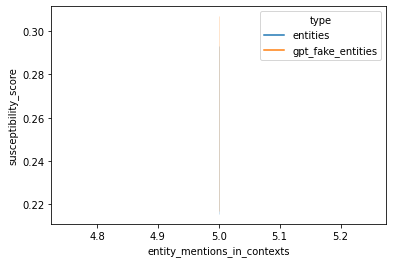

In [36]:
val_df_per_qe["entity_mentions_in_contexts"] = val_df_per_qe.apply(
    lambda row: sum([row["entity"][0] in context for context in row["contexts"]]),
    axis=1,
)
sns.lineplot(
    data=val_df_per_qe,
    x="entity_mentions_in_contexts",
    y="susceptibility_score",
    hue="type",
)
# val_df_per_qe

In [37]:
def construct_df_given_query_id(query_id: str, verbose=True):
    # Construct paths from run parameters and construct DATASET_KWARGS_IDENTIFIABLE
    (
        data_dir,
        input_dir,
        entities_path,
        contexts_path,
        queries_path,
        answers_path,
        val_data_path,
        model_dir,
        results_dir,
        val_results_path,
        data_id,
        model_id,
        DATASET_KWARGS_IDENTIFIABLE,
    ) = construct_paths_and_dataset_kwargs(
        DATASET_NAME=DATASET_NAME,
        RAW_DATA_PATH=RAW_DATA_PATH,
        SEED=SEED,
        MODEL_ID=MODEL_ID,
        LOAD_IN_8BIT=LOAD_IN_8BIT,
        QUERY_ID=query_id,
        MAX_CONTEXTS=MAX_CONTEXTS,
        MAX_ENTITIES=MAX_ENTITIES,
        CAP_PER_TYPE=CAP_PER_TYPE,
        UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
        DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
        ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
        OVERWRITE=OVERWRITE,
        ENTITY_TYPES=ENTITY_TYPES,
        QUERY_TYPES=QUERY_TYPES,
        ANSWER_MAP=ANSWER_MAP,
    )
    # Analysis dir
    analysis_dir = os.path.join(data_dir, "analysis")
    if verbose:
        print(f"Analysis dir: {analysis_dir}")
    os.makedirs(input_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(analysis_dir, exist_ok=True)

    # Set random seeds
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    from ast import literal_eval

    try:
        val_df_contexts_per_qe = pd.read_csv(
            val_results_path,
            index_col=0,
            converters={"contexts": literal_eval, "entity": literal_eval},
        )
    except FileNotFoundError as e:
        print(f"Unable to find file at {val_results_path}, full error: {e}")
        return None
    if verbose:
        print("val_df_contexts_per_qe info:")
        print(val_df_contexts_per_qe.info())
        print(val_df_contexts_per_qe["entity"].value_counts())
        print(val_df_contexts_per_qe.iloc[0]["contexts"][:10])

    entities_df_tidy = pd.DataFrame(
        [
            (k, ent)
            for k, ents in yago_qec[query_id].items()
            for ent in ents
            if k in {"entities", "fake_entities", "gpt_fake_entities"}
        ],
        columns=["type", "entity"],
    )
    entities_df_tidy["entity"] = entities_df_tidy["entity"].apply(lambda x: (x,))

    #     entities_df = pd.DataFrame(
    #         {
    #             k: v
    #             for k, v in yago_qec[query_id].items()
    #             if k in {"entities", "fake_entities"}
    #         }
    #     )
    #     real_ents = set(entities_df["entities"])
    #     fake_ents = set(entities_df["fake_entities"])

    #     entities_df_tidy = entities_df.melt(var_name="type", value_name="entity")
    #     entities_df_tidy["entity"] = entities_df_tidy["entity"].apply(lambda x: (x,))
    #     entities_df_tidy = entities_df_tidy.drop_duplicates()
    #     if verbose:
    #         print("Entities info:")
    #         print("# unique real ents:", len(real_ents))
    #         print("# unique fake ents:", len(fake_ents))
    #         print("# overlapping ents:", len(real_ents.intersection(fake_ents)))
    #         print("Overlapping ents:", real_ents.intersection(fake_ents))
    #         print(
    #             entities_df["entities"].value_counts(),
    #             entities_df["fake_entities"].value_counts(),
    #         )
    #         print(entities_df_tidy.head())
    #         print(entities_df_tidy.info())

    val_df_per_qe = val_df_contexts_per_qe.merge(
        entities_df_tidy,
        left_on="entity",
        right_on="entity",
        how="left",
    )[
        [
            "q_id",
            "query_form",
            "entity",
            "answer",
            "contexts",
            "type",
            "susceptibility_score",
        ]
    ]
    val_df_per_qe = val_df_per_qe.merge(qids_to_ec)  # add entity types

    query_forms = val_df_per_qe["query_form"].unique()
    closed_qfs = yago_qec[query_id]["query_forms"]["closed"]
    open_qfs = yago_qec[query_id]["query_forms"]["open"]

    val_df_per_qe.loc[
        val_df_per_qe["query_form"].isin(closed_qfs), "query_type"
    ] = "closed"
    val_df_per_qe.loc[val_df_per_qe["query_form"].isin(open_qfs), "query_type"] = "open"

    if verbose:
        print("val_df_per_qe info:")
        print(val_df_per_qe)

        print(f"query forms: {query_forms}")
        print(
            "Sorted sus scores:",
            val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]].sort_values(
                by="susceptibility_score"
            ),
        )

    return val_df_per_qe

In [38]:
qid_to_val_df_per_qe = {
    query_id: construct_df_given_query_id(query_id, verbose=False)
    for query_id in QUERY_IDS
}

Data dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0
Model dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/models/EleutherAI/pythia-6.9b-deduped-8bit
Data dir: data/YagoECQ/schema_duration/schema_duration-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0
Model dir: data/YagoECQ/schema_duration/schema_duration-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/models/EleutherAI/pythia-6.9b-deduped-8bit
Data dir: data/YagoECQ/reverse-schema_director/reverse-schema_director-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0
Model dir: data/YagoECQ/reverse-schema_director/reverse-schema_director-mc500-me100-uniformcontexts-dedupeentities-ET_entities_gpt_fake_entities-QT_closed_open/0/models/El

In [39]:
print(
    "No results for:",
    {k for k in qid_to_val_df_per_qe if qid_to_val_df_per_qe[k] is None},
)
qid_to_val_df_per_qe = {k: v for k, v in qid_to_val_df_per_qe.items() if v is not None}

No results for: {'http://schema.org/editor', 'http://schema.org/founder', 'reverse-http://schema.org/editor', 'http://schema.org/award', 'http://schema.org/motto', 'http://schema.org/gtin'}


In [ ]:
import math

num_plots = len(qid_to_val_df_per_qe)
num_cols = 3
num_rows = math.ceil(num_plots // 3) + 1
fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(20, 100))

count = 0
for qid, df in qid_to_val_df_per_qe.items():
    row = math.ceil(count // num_cols)
    col = count % num_cols
    ax = axes[row][col]
    sns.swarmplot(
        data=df,
        x="query_form",
        y="susceptibility_score",
        hue="type",
        ax=ax,
        size=1,
        hue_order=ENTITY_TYPES,
        # hue="is_real",
        # dodge=True
        # jitter=0.1,
        # legend="full",
    )
    subname = (
        f"{extract_name_from_yago_uri(qid)[0]}_{extract_name_from_yago_uri(qid)[1]}"
    )
    ax.set_title(subname)
    for tick in ax.get_xticklabels():
        tick.set_rotation(15)
    count += 1
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_all"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})


KeyboardInterrupt



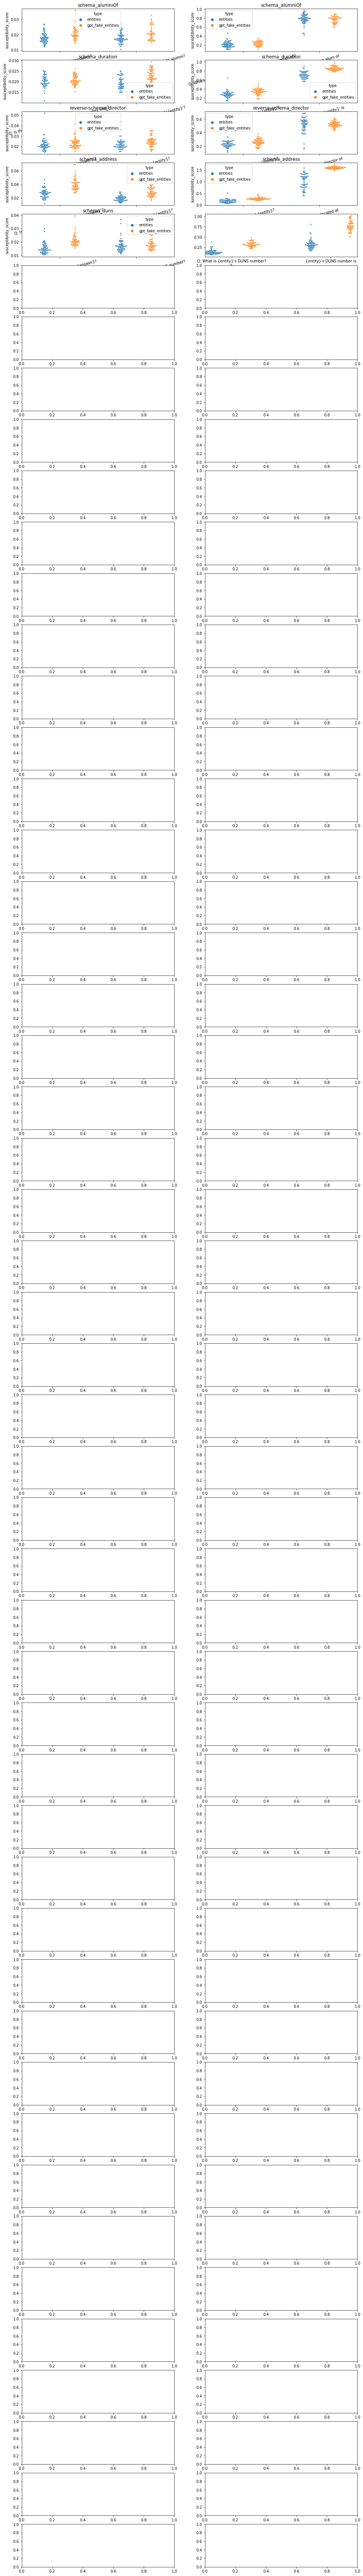

Error in callback <function _WandbInit._pause_backend at 0x2ad5a9bc79a0> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [44]:
import math

num_rows = len(qid_to_val_df_per_qe)
num_cols = 2
fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(8, 250))

count = 0
for qid, df in qid_to_val_df_per_qe.items():
    for qt in ["closed", "open"]:
        row = math.ceil(count // num_cols)
        col = count % num_cols
        ax = axes[row][col]
        sns.swarmplot(
            data=df[df["query_type"] == qt],
            x="query_form",
            y="susceptibility_score",
            hue="type",
            ax=ax,
            size=3,
            hue_order=ENTITY_TYPES,
            # hue="is_real",
            dodge=True,
            # jitter=0.1,
            # legend="full",
        )
        subname = (
            f"{extract_name_from_yago_uri(qid)[0]}_{extract_name_from_yago_uri(qid)[1]}"
        )
        ax.set_title(subname)
        for tick in ax.get_xticklabels():
            tick.set_rotation(15)
        count += 1
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_all_open_vs_closed"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 9.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cluster/home/kevidu/.local/lib/python3.10/site-p

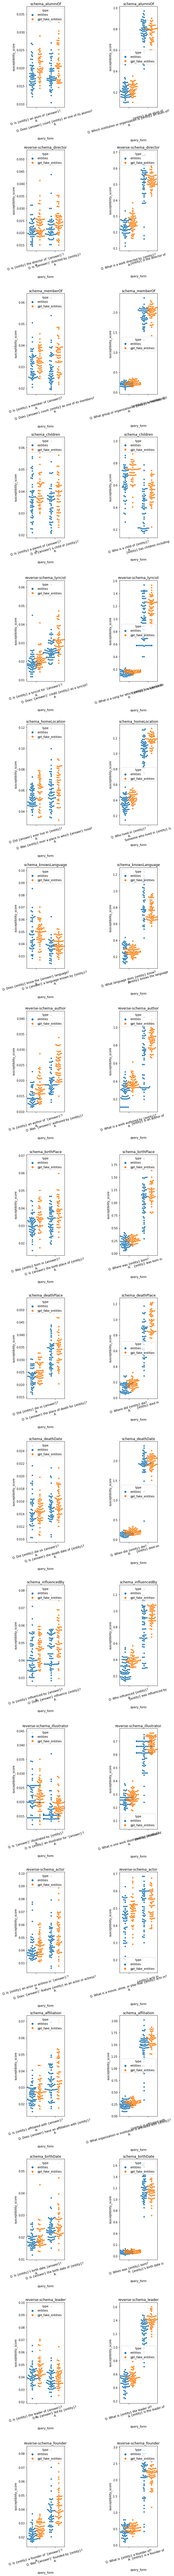

In [40]:
import math


person_plots = {
    k: df
    for k, df in qid_to_val_df_per_qe.items()
    if "http://schema.org/Person" in df["entity_classes"].iloc[0]
}

num_rows = len(person_plots)
num_cols = 2
fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(8, 125))

count = 0
for qid, df in list(person_plots.items()):
    for qt in ["closed", "open"]:
        row = math.ceil(count // num_cols)
        col = count % num_cols
        ax = axes[row][col]
        sns.swarmplot(
            data=df[df["query_type"] == qt],
            x="query_form",
            y="susceptibility_score",
            hue="type",
            ax=ax,
            # size=3,
            hue_order=ENTITY_TYPES,
            # hue="is_real",
            dodge=True,
            # jitter=0.1,
            # legend="full",
        )
        subname = (
            f"{extract_name_from_yago_uri(qid)[0]}_{extract_name_from_yago_uri(qid)[1]}"
        )
        ax.set_title(subname)
        for tick in ax.get_xticklabels():
            tick.set_rotation(15)
        count += 1
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_person-only_open_vs_closed"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cluster/home/kevidu/.local/lib/python3.10/site-pa

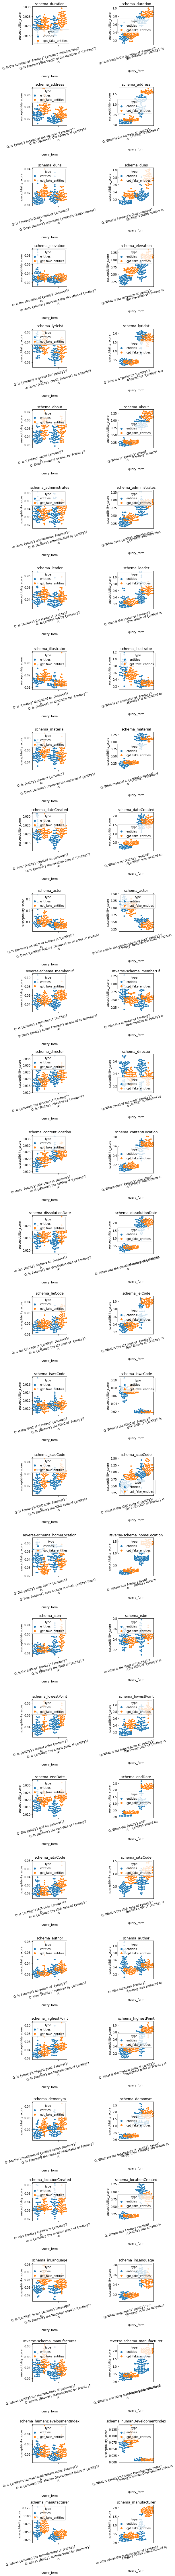

In [41]:
import math


not_person_plots = {
    k: df
    for k, df in qid_to_val_df_per_qe.items()
    if "http://schema.org/Person" not in df["entity_classes"].iloc[0]
}

num_rows = len(not_person_plots)
num_cols = 2
fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(8, 125))

count = 0
for qid, df in list(not_person_plots.items()):
    for qt in ["closed", "open"]:
        row = math.ceil(count // num_cols)
        col = count % num_cols
        ax = axes[row][col]
        sns.swarmplot(
            data=df[df["query_type"] == qt],
            x="query_form",
            y="susceptibility_score",
            hue="type",
            ax=ax,
            # size=3,
            hue_order=ENTITY_TYPES,
            # hue="is_real",
            dodge=True,
            # jitter=0.1,
            # legend="full",
        )
        subname = (
            f"{extract_name_from_yago_uri(qid)[0]}_{extract_name_from_yago_uri(qid)[1]}"
        )
        ax.set_title(subname)
        for tick in ax.get_xticklabels():
            tick.set_rotation(15)
        count += 1
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_not-person-only_open_vs_closed"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

In [44]:
from scipy.stats import ttest_ind


def ttest(df, group1="entities", group2="fake_entities"):
    sus_scores_real = df[df["type"] == group1]["susceptibility_score"]
    sus_scores_fake = df[df["type"] == group2]["susceptibility_score"]
    ttest_ind(sus_scores_real, sus_scores_fake, alternative="less")
    ttest_res = ttest_ind(sus_scores_real, sus_scores_fake, alternative="less")
    t_stat, p_value = ttest_res.statistic, ttest_res.pvalue
    # print(t_stat, p_value)
    cohen_d = t_stat * np.sqrt(
        (len(sus_scores_real) + len(sus_scores_fake))
        / (len(sus_scores_real) * len(sus_scores_fake))
    )
    cohen_d2 = (np.mean(sus_scores_real) - np.mean(sus_scores_fake)) / np.sqrt(
        (
            np.var(sus_scores_real, ddof=1) * (len(sus_scores_real) - 1)
            + np.var(sus_scores_fake, ddof=1) * (len(sus_scores_fake) - 1)
        )
        / (len(sus_scores_real) + len(sus_scores_fake) - 2)
    )
    assert np.isclose(cohen_d, cohen_d2)
    # effect_size,
    return {
        "effect_size": cohen_d,
        "p_value": p_value,
        "n": len(sus_scores_fake) + len(sus_scores_real),
    }


# ttest_scores = [{"query": k, **ttest(v)} for k, v in qid_to_val_df_per_qe.items()]
ttest_scores = [
    {
        "query": k,
        **ttest(
            v[v["query_type"] == "closed"],
            group1="entities",
            group2="gpt_fake_entities",
        ),
    }
    for k, v in qid_to_val_df_per_qe.items()
]
ttest_scores = [
    {
        "query": k,
        **ttest(
            v[v["query_type"] == "closed"],
            group1="entities",
            group2="gpt_fake_entities",
        ),
    }
    for k, v in qid_to_val_df_per_qe.items()
    if "http://schema.org/Person" not in v["entity_classes"].iloc[0]
]
# ttest_scores = [
#     {
#         "query": k,
#         **ttest(
#             v[v["query_type"] == "open"],
#             group1="entities",
#             group2="gpt_fake_entities",
#         ),
#     }
#     for k, v in qid_to_val_df_per_qe.items()
# ]
pd.DataFrame(ttest_scores).sort_values(by="p_value").reset_index(drop=True)

query  effect_size       p_value    n
0              http://schema.org/inLanguage    -1.687454  5.020646e-25  200
1                 http://schema.org/address    -1.387024  4.693734e-19  200
2                 http://schema.org/endDate    -1.380651  7.032010e-19  200
3                   http://schema.org/about    -1.215181  9.245374e-16  202
4                 http://schema.org/demonym    -1.032515  1.393541e-13  230
5             http://schema.org/lowestPoint    -1.099034  6.832571e-13  202
6    reverse-http://schema.org/manufacturer    -0.897331  1.348263e-12  284
7                http://schema.org/icaoCode    -1.027045  4.878194e-12  200
8                 http://schema.org/leiCode    -0.946160  1.123143e-10  200
9         http://schema.org/dissolutionDate    -0.879906  1.694089e-09  200
10            http://schema.org/dateCreated    -0.846989  5.014062e-09  200
11               http://schema.org/duration    -0.776032  6.749270e-08  200
12                   http://schema.org/duns    -0.743253  2.059616e-07  200
13                 http://schema.org/leader    -0.719548  2.696285e-07  210
14       reverse-http://schema.org/memberOf    -0.685641  7.056867e-07  210
15           http://schema.org/manufacturer    -0.664382  3.007203e-06  200
16                   http://schema.org/isbn    -0.633334  7.280918e-06  200
17               http://schema.org/lyricist    -0.554727  5.160924e-05  204
18        http://schema.org/contentLocation    -0.555130  5.866425e-05  202
19            http://schema.org/illustrator    -0.460407  5.775123e-04  206
20               http://schema.org/iataCode    -0.467383  5.963015e-04  200
21               http://schema.org/material    -0.460811  6.098309e-04  204
22               http://schema.org/director    -0.415894  1.955698e-03  200
23                 http://schema.org/author    -0.342138  8.399331e-03  200
24  http://schema.org/humanDevelopmentIndex    -0.337439  8.986306e-03  200
25           http://schema.org/highestPoint    -0.297378  1.867460e-02  200
26          http://schema.org/administrates    -0.143555  1.466827e-01  220
27              http://schema.org/elevation    -0.082874  2.799281e-01  202
28        http://schema.org/locationCreated    -0.045127  3.753828e-01  200
29                  http://schema.org/actor     0.048176  6.305481e-01  200
30               http://schema.org/iswcCode     0.230940  9.473962e-01  202
31   reverse-http://schema.org/homeLocation     1.003794  1.000000e+00  262

In [ ]:
construct_df_given_query_id("reverse-http://schema.org/manufacturer", verbose=True)
# qid_to_val_df_per_qe["reverse-http://schema.org/manufacturer"]["type"].value_counts()

### Examining model outputs

In [ ]:
# TODO: (1) try answer_map thing, and also (2) randomly sample so that each entity shows up in contexts evenly

In [ ]:
from measuring.estimate_probs import (
    # estimate_prob_y_given_context_and_entity,
    # estimate_prob_x_given_e,
    # estimate_prob_next_word_given_x_and_entity,
    estimate_cmi,
    get_prob_next_word,
    #     score_model_for_next_word_prob,
    #     create_position_ids_from_input_ids,
    #     sharded_score_model,
    #     estimate_entity_score,
    #     kl_div,
    #     difference,
    #     difference_p_good_only,
    #     difference_abs_val,
)
from preprocessing.utils import format_query
import pprint

In [ ]:
try:
    model = GPTNeoXForCausalLM.from_pretrained(
        MODEL_ID, load_in_8bit=LOAD_IN_8BIT, device_map="auto"
    )
except:
    print(f"Failed to load model {MODEL_ID} in 8-bit. Attempting to load normally.")
    model = GPTNeoXForCausalLM.from_pretrained(
        MODEL_ID,
        load_in_8bit=False,
    ).to(device)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    padding_side="left",
)

In [ ]:
val_df_contexts_per_qe.sort_values(by="susceptibility_score").iloc[0]

In [ ]:
def print_top_k_next_token_probs(
    model, tokenizer, query, entity, context, answer=None, k=50
):
    logits, inds = torch.topk(
        get_prob_next_word(
            model,
            tokenizer(
                format_query(
                    query=query, entity=entity, context=context, answer=answer
                ),
                padding=True,
                return_tensors="pt",
            ).to(model.device),
        ),
        k=k,
    )
    print(
        list(
            zip(
                torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                tokenizer.convert_ids_to_tokens(inds[0]),
                inds[0].detach().cpu().numpy(),
            )
        )
    )

In [ ]:
val_df_contexts_per_qe.info(), val_df_per_qe.info()

In [ ]:
val_df_per_qe.drop(
    columns=["contexts", "type", "q_id", "entity_mentions_in_contexts"]
).value_counts()

In [ ]:
query_forms = val_df_per_qe["query_form"].unique()
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]].sort_values(
    by="susceptibility_score"
)

In [ ]:
entity_to_context_mentions = {
    entity: sum([entity[0] in context for context in val_df_per_qe.iloc[0]["contexts"]])
    for entity in val_df_per_qe["entity"].unique()
}
entity_to_context_mentions = dict(
    sorted(entity_to_context_mentions.items(), key=lambda x: x[1])
)
print("Number of contexts each entity is mentioned in:")
entity_to_context_mentions

In [ ]:
pp = pprint.PrettyPrinter()
query_id = "reverse-http://schema.org/manufacturer"
val_df_per_qe = qid_to_val_df_per_qe[query_id]
# print(val_df_per_qe)
row = (
    val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]]
    .sort_values(by="susceptibility_score")
    .iloc[0]
)
entity = row["entity"]
answer = row["answer"]
print("entity:", entity)
contexts = row["contexts"]
query = row["query_form"]
print(f"***Investigating the following query for entity {entity}:***")
print(format_query(query=query, entity=entity, context="", answer=answer))
print(
    "CMI:",
    estimate_cmi(query, entity, contexts, model, tokenizer, answer_entity=answer),
)

print("***Top-k next token probs WITHOUT any context:***")
print_top_k_next_token_probs(
    model, tokenizer, query, entity, context="", k=50, answer=answer
)
print("\n\n")
print("Top-k next token probs WITH context mentioning entity")
for context in contexts:
    if entity[0] in context:
        print(
            f"*{format_query(query=query, entity=entity, context=context, answer=answer)}*"
        )
        print_top_k_next_token_probs(
            model, tokenizer, query, entity, context, k=50, answer=answer
        )
        print("\n\n")
print("\n\n")
print("Top-k next token probs WITH context NOT mentioning entity")
for context in contexts[:5]:
    print(
        f"*{format_query(query=query, entity=entity, context=context, answer=answer)}*"
    )
    print_top_k_next_token_probs(
        model, tokenizer, query, entity, context, k=50, answer=answer
    )
    print("\n\n")


print("***Sampled next 5 generated tokens WITHOUT any context:***")
tokens = tokenizer(
    format_query(query=query, entity=entity, context="", answer=answer),
    padding=True,
    return_tensors="pt",
).to(model.device)
print(f"Prompt length:{len(tokens['input_ids'][0])}")
samples = model.generate(
    **tokens,
    num_return_sequences=10,
    do_sample=True,
    max_length=len(tokens["input_ids"][0]) + 5,
)
pp.pprint(list(zip(tokenizer.batch_decode(samples), [s[-5:] for s in samples])))

In [ ]:
tokenizer([" Nope"])

### Correlation with Pile frequency

In [ ]:
unigram_frequencies = np.memmap(
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia-unigrams.bin",
    dtype=np.int64,
    mode="r",
    shape=(50277,),
)
view = np.memmap(
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia_pile_idxmaps/pile_0.87_deduped_text_document.bin",
    dtype=np.uint16,
    mode="r",
)

In [ ]:
import zstandard as zstd
import pickle
from scipy.sparse import load_npz

file_path = (
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia-deduped-bigrams.zst"
)
# # Open the zstd file for reading in binary mode
# with open(file_path, 'rb') as compressed_file:
#     dctx = zstd.ZstdDecompressor()
#     with dctx.stream_reader(compressed_file) as reader:
#         # Decompress the zstd file and load the pickled data
#         pickled_data = pickle.loads(reader.read())

# Reconstruct the SciPy sparse array
# sparse_array = load_npz(pickled_data)

with open(file_path, "rb") as f:
    data = f.read()

dctx = zstd.ZstdDecompressor()
decompressed = dctx.decompress(data)
pickled_scipy = pickle.loads(decompressed)

In [ ]:
len(decompressed), type(decompressed), decompressed[:5]

In [ ]:
entities = val_df_contexts_per_qe["entity"].apply(lambda x: x[0]).unique().tolist()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    padding_side="left",
)
tokenized_entities = [tuple(e) for e in tokenizer(entities)["input_ids"]]
tokenized_entities_prespace = [
    tuple(e) for e in tokenizer([" " + e for e in entities])["input_ids"]
]
tokenized_entities
tokenized_entities_prespace
entities_to_freqs = {
    e: {tokenized_entities[i]: 0, tokenized_entities_prespace[i]: 0}
    for i, e in enumerate(entities)
}
entities_to_freqs["Zimbabwe"]

# tokenized_entities
# {
#     entity:
#         {
#             tokens_without_space: count,
#             tokens_with_space: count
#         }
# }

In [ ]:
# relevant_token_seqs = set(tokenized_entities + tokenized_entities_prespace)
relevant_token_seqs = set(tokenized_entities_prespace)
relevant_token_seqs

In [ ]:
from collections import Counter

unigram_tokens = {
    t: unigram_frequencies[t[0]] for t in relevant_token_seqs if len(t) == 1
}
unigram_tokens

In [ ]:
bigram_tokens = {
    t: bigram_frequencies[t[0]] for t in relevant_token_seqs if len(t) == 2
}

In [ ]:
for e, freq_dicts in entities_to_freqs.items():
    total = 0
    for token_seqs in freq_dicts.keys():
        if len(token_seqs) == 1:
            freq_dicts[token_seqs] = unigram_frequencies[token_seqs[0]]
        if len(token_seqs) == 2:
            freq_dicts[token_seqs] = bigram_frequencies[token_seqs]
        total += freq_dicts[token_seqs]
    freq_dicts["total"] = total

In [ ]:
entities_to_freqs

In [ ]:
entity_counts = dict(
    sorted(
        {
            (k,): v["total"] for k, v in entities_to_freqs.items() if v["total"] != 0
        }.items(),
        key=lambda x: x[1],
    )
)
ent_freq_df = pd.DataFrame(
    list(entity_counts.items()), columns=["entity", "ent_frequency"]
)
ent_freq_df

In [ ]:
val_df_per_qe_with_freq = val_df_per_qe.merge(ent_freq_df)
val_df_per_qe_with_freq["log_ent_frequency"] = val_df_per_qe_with_freq[
    "ent_frequency"
].apply(np.log)
val_df_per_qe_with_freq

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
df = val_df_per_qe_with_freq[val_df_per_qe_with_freq["query_form"] == query_forms[0]]
plot = sns.regplot(
    data=df,
    x="log_ent_frequency",
    y="susceptibility_score",
    # logx=True,
    # hue="query_form",
    ax=ax,
    label=True,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

for i, row in df.iterrows():
    ax.text(
        row["log_ent_frequency"],
        row["susceptibility_score"],
        row["entity"],
        ha="right",
        va="bottom",
    )

plot_name = "plot_susscore_vs_queryform_real_historical_dreamfic_ent_frequency"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path)
wandb.log({plot_name: wandb.Image(fig)})

In [ ]:
# 24000 min = 2+ weeks of CPU hours to finish lmao
from tqdm.auto import trange
CHUNK_SIZE = 50_000_000
VOCAB_SIZE = 50_277
window_size = 1
for i in trange(0, len(view), CHUNK_SIZE):
    chunk = view[i : i + CHUNK_SIZE]
    for j in trange(len(chunk) - (window_size - 1)):
        ngram = tuple(chunk[j: j+window_size])
        if ngram in unigram_tokens:
            unigram_tokens[ngram] += 1        
    # counts += np.bincount(chunk, minlength=len(counts))

In [ ]:
unigram_frequencies

In [ ]:
tokenizer.convert_ids_to_tokens([38581])

In [ ]:
wandb.finish()